# BERTopic Hyperparameter Optimization (Supervised Approach)

In this notebook, I applied BERTopic to perform topic modeling on textual data. First, I used an unsupervised approach to automatically discover latent topics based on semantic similarity between documents.

Next, I optimized key model hyperparameters to improve topic quality, evaluating the results using topic coherence, topic diversity, and the number of topics. This allowed me to select a configuration that balances interpretability and topic separation.

Finally, I applied supervised topic modeling by incorporating predefined report sections as labels. This helped generate more structured and interpretable topics aligned with the report structure.

Overall, the notebook demonstrates a complete topic modeling workflow, from exploration to optimization and evaluation.


In [3]:
%pip install pandas==2.1.4 pyarrow==14.0.2




  Using cached pandas-2.1.4-cp310-cp310-win_amd64.whl.metadata (18 kB)
  Using cached pyarrow-14.0.2-cp310-cp310-win_amd64.whl.metadata (3.1 kB)
  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
Using cached pandas-2.1.4-cp310-cp310-win_amd64.whl (10.7 MB)
Using cached pyarrow-14.0.2-cp310-cp310-win_amd64.whl (24.6 MB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)

   ---------------------------------------- 0/5 [pytz]
   ---------------------------------------- 0/5 [pytz]
   ---------------------------------------- 0/5 [pytz]
   ---------------------------------------- 0/5 [pytz]
   ---------------------------------------- 0/5 [pytz]
   ---------------------------------------- 0/5 [pytz]
   ---------------------------------------- 0/5 [pytz]
   ---------------------------------------- 0/5 [pytz]
   ---------------------------------------- 0/5 [pytz]
   -------- ------------------------------- 1/5 [tzdata]
   -------- ------------------------------

In [5]:
import pandas as pd

path = r"output.csv"
df = pd.read_csv(path)

df.head()


,year,country,is_eu,section,source_file,chunk_id,text
0,2013,Afghanistan,False,EXECUTIVE SUMMARY,Afghanistan.txt,Afghanistan.txt::EXECUTIVE SUMMARY::0,Share Afghanistan is an Islamic republic with ...
1,2013,Afghanistan,False,Section 1.,Afghanistan.txt,Afghanistan.txt::Section 1.::0,"Respect for the Integrity of the Person, Inclu..."
2,2013,Afghanistan,False,Section 1.,Afghanistan.txt,Afghanistan.txt::Section 1.::1,"judges, prosecutors, and clerical staff. In Ju..."
3,2013,Afghanistan,False,Section 1.,Afghanistan.txt,Afghanistan.txt::Section 1.::2,were reports that insurgent groups were respon...
4,2013,Afghanistan,False,Section 1.,Afghanistan.txt,Afghanistan.txt::Section 1.::3,with fists and electric cables; kicking; choki...


In [8]:
df.groupby(["year"])["country"].nunique(), df["is_eu"].mean()

(year
 2013    195
 2014    195
 2015    195
 Name: country, dtype: int64,
 0.10293074481986186)

In [9]:
docs_all = df["text"].tolist()
tokenized_docs = [d.split() for d in docs_all]


In [ ]:
def chunk_text(text, chunk_size=300, overlap=50):
    words = text.split()
    chunks = []
    start = 0

    while start < len(words):
        end = start + chunk_size
        chunk = " ".join(words[start:end])
        chunks.append(chunk)
        start += chunk_size - overlap

    return chunks


rows = []
for idx, row in df.iterrows():
    chunks = chunk_text(row["text"])
    for c in chunks:
        rows.append({
            "doc_id": idx,
            "chunk_text": c
        })

chunk_df = pd.DataFrame(rows)

print("Original docs:", len(df))
print("Chunks:", len(chunk_df))


Original docs: 26785
Chunks: 26785


UNSUPERVISED TOPIC MODELING (BERTopic)

In [11]:
%pip uninstall torch torchvision torchaudio -y


Found existing installation: torch 2.9.1+cpu
Uninstalling torch-2.9.1+cpu:
  Successfully uninstalled torch-2.9.1+cpu
Found existing installation: torchvision 0.24.1+cpu
Uninstalling torchvision-0.24.1+cpu:
  Successfully uninstalled torchvision-0.24.1+cpu
Found existing installation: torchaudio 2.9.1+cpu
Uninstalling torchaudio-2.9.1+cpu:
  Successfully uninstalled torchaudio-2.9.1+cpu
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpuNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/113.6 MB ? eta -:--:--
   - -------------------------------------- 3.1/113.6 MB 14.2 MB/s eta 0:00:08
   -- ------------------------------------- 6.8/113.6 MB 15.5 MB/s eta 0:00:07
   --- ------------------------------------ 10.2/113.6 MB 15.5 MB/s eta 0:00:07
   ---- ----------------------------------- 13.6/113.6 MB 15.6 MB/s eta 0:00:07
   ----- ---------------------------------- 16.8/113.6 MB 15.6 MB/s eta 0:00:07
   ------- -------------------------------- 19.9/113.6 MB 15.2 MB/s eta 0:00:07
   -------- ------------------------------- 23.1/113.6 MB 15.2 MB/s eta 0:00:06
   --------- ------------------------------ 26.0/113.6 MB 14.9 MB/s eta 0:00:06
   ---------- ----------------------------- 29.1/113.6 MB 14.9 MB/s eta 0:00:06
   ----------- ---------------------------- 32.2/113.6 MB 14.9 MB/s eta 0:00:06
   -----

In [15]:
# Install the required libraries
from sentence_transformers import SentenceTransformer

# Ensure that docs_all is defined (execute CELL INDEX 4 first)
# Use CPU-only version of PyTorch to avoid DLL initialization errors
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")  # Force CPU usage
embeddings = embedding_model.encode(
    docs_all,
    show_progress_bar=True
)


OSError: [WinError 1114] A dynamic link library (DLL) initialization routine failed. Error loading "c:\Users\ozdil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\lib\c10.dll" or one of its dependencies.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    stop_words="english",
    min_df=3,
    max_df=0.9,
    ngram_range=(1, 2)
)


In [ ]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(
    n_neighbors=10,
    n_components=5,
    metric="cosine",
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    min_samples=1,
    metric="euclidean"
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics="auto",        # safety net
    verbose=True
)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
%pip install bertopic==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
topics, probs = topic_model.fit_transform(docs_all, embeddings)


2026-01-17 15:41:44,400 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-17 15:42:38,768 - BERTopic - Dimensionality - Completed ✓
2026-01-17 15:42:38,770 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-17 15:42:47,632 - BERTopic - Cluster - Completed ✓
2026-01-17 15:42:47,633 - BERTopic - Representation - Extracting topics from clusters using representation models.
2026-01-17 15:43:15,106 - BERTopic - Representation - Completed ✓
2026-01-17 15:43:15,115 - BERTopic - Topic reduction - Reducing number of topics
2026-01-17 15:44:03,797 - BERTopic - Topic reduction - Reduced number of topics from 3551 to 2000


In [ ]:
topic_model.get_topic_info().head()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,7196,-1_detention_disabilities_authorities_prison,"[detention, disabilities, authorities, prison,...","[of, or lack of compliance with, child labor l..."
1,0,2777,0_labor_workers_unions_child labor,"[labor, workers, unions, child labor, employer...",[Worker Rights Share a. Freedom of Association...
2,1,822,1_international child_pornography_sexual explo...,"[international child, pornography, sexual expl...",[Morals of the National Police conducted sweep...
3,2,710,2_corruption_disclosure_public access_financia...,"[corruption, disclosure, public access, financ...",[Corruption and Lack of Transparency in Govern...
4,3,436,3_elections_change government_participation_po...,"[elections, change government, participation, ...",[Respect for Political Rights: The Right of Ci...


In [ ]:
topic_info = topic_model.get_topic_info().copy()

# Exclude outliers for interpretation
main_topics = topic_info[topic_info["Topic"] != -1].copy()

# Add share
main_topics["share"] = main_topics["Count"] / main_topics["Count"].sum()

main_topics.head(30)[["Topic","Count","share","Name"]]


,Topic,Count,share,Name
1,0,2777,0.141763,0_labor_workers_unions_child labor
2,1,822,0.041962,1_international child_pornography_sexual explo...
3,2,710,0.036245,2_corruption_disclosure_public access_financia...
4,3,436,0.022257,3_elections_change government_participation_po...
5,4,411,0.020981,4_rape_spousal_domestic violence_spousal rape
6,5,399,0.020369,5_nongovernmental investigation_attitude regar...
7,6,354,0.018071,6_lgbt_aids_hiv_hiv aids
8,7,324,0.016540,7_arrest detention_independent monitoring_arbi...
9,8,189,0.009648,8_fgm_sexual harassment_mutilation_genital
10,9,186,0.009495,9_protection refugees_movement_internally disp...


In [ ]:
valid_topic_ids = [
    t for t in set(topics)
    if t != -1
]

len(valid_topic_ids)


1999

In [ ]:
def extract_topic_words(model, topic_ids, topn=10):
    topic_words = []

    for tid in topic_ids:
        topic = model.get_topic(tid)

        # 🔴 skip empty or invalid topics
        if topic is None:
            continue

        words = [w for w, _ in topic if isinstance(w, str)]

        if len(words) >= 2:  # Gensim needs at least 2 words
            topic_words.append(words[:topn])



    return topic_words


In [ ]:
%pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 15.5 MB/s eta 0:00:00


In [ ]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

def coherence_cv(tokenized_docs, topic_words):
    dictionary = Dictionary(tokenized_docs)

    # ╓ remove words not in dictionary
    filtered_topics = [
        [w for w in topic if w in dictionary.token2id]
        for topic in topic_words
    ]

    filtered_topics = [t for t in filtered_topics if len(t) >= 2]

    corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

    cm = CoherenceModel(
        topics=filtered_topics,
        texts=tokenized_docs,
        corpus=corpus,
        dictionary=dictionary,
        coherence="c_v"
    )

    return cm.get_coherence()

In [ ]:

def topic_diversity(topic_words, topk=10):
    all_words = []
    for words in topic_words:
        all_words.extend(words[:topk])
    return len(set(all_words)) / len(all_words)




In [ ]:
topic_words = extract_topic_words(
    topic_model,
    valid_topic_ids,
    topn=10
)

len(topic_words)

1999

In [ ]:
coh = coherence_cv(tokenized_docs, topic_words)
div = topic_diversity(topic_words)


Hyperparameter Optimization

In [ ]:
base_params = {
    "n_neighbors": 10,
    "n_components": 5,
    "min_cluster_size": 3,
    "min_samples": 1
}


In [ ]:
configs = [
    {**base_params},  # baseline
    {**base_params, "min_cluster_size": 5},
    {**base_params, "n_neighbors": 15},
]


In [ ]:
def build_model_from_params(params):
    umap_model = UMAP(
        n_neighbors=params["n_neighbors"],
        n_components=params["n_components"],
        metric="cosine",
        random_state=42
    )

    hdbscan_model = HDBSCAN(
        min_cluster_size=params["min_cluster_size"],
        min_samples=params["min_samples"],
        metric="euclidean"
    )

    model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        nr_topics="auto",
        verbose=False
    )

    return model


In [ ]:
results = []

for i, params in enumerate(configs):
    print(f"Running config {i+1}: {params}")

    model = build_model_from_params(params)
    topics, _ = model.fit_transform(docs_all, embeddings)

    valid_topic_ids = [t for t in set(topics) if t != -1]

    topic_words = extract_topic_words(model, valid_topic_ids, topn=10)

    if len(topic_words) < 2:
        print("  → skipped (too few valid topics)")
        continue

    coh = coherence_cv(tokenized_docs, topic_words)
    div = topic_diversity(topic_words)

    results.append({
        "config_id": i + 1,
        **params,
        "n_topics": len(topic_words),
        "coherence_c_v": coh,
        "topic_diversity": div
    })


Running config 1: {'n_neighbors': 10, 'n_components': 5, 'min_cluster_size': 3, 'min_samples': 1}
Running config 2: {'n_neighbors': 10, 'n_components': 5, 'min_cluster_size': 5, 'min_samples': 1}
Running config 3: {'n_neighbors': 15, 'n_components': 5, 'min_cluster_size': 3, 'min_samples': 1}


In [ ]:
results_df = pd.DataFrame(results)
results_df


,config_id,n_neighbors,n_components,min_cluster_size,min_samples,n_topics,coherence_c_v,topic_diversity
0,1,10,5,3,1,1999,0.692529,0.767284
1,2,10,5,5,1,772,0.698314,0.693135
2,3,15,5,3,1,1935,0.675126,0.753023


In [ ]:
results_df["score"] = (
    0.7 * results_df["coherence_c_v"] +
    0.3 * results_df["topic_diversity"]
)

results_df.sort_values("score", ascending=False)


,config_id,n_neighbors,n_components,min_cluster_size,min_samples,n_topics,coherence_c_v,topic_diversity,score
0,1,10,5,3,1,1999,0.692529,0.767284,0.714955
2,3,15,5,3,1,1935,0.675126,0.753023,0.698495
1,2,10,5,5,1,772,0.698314,0.693135,0.696760


In [ ]:
best_params = results_df.sort_values(
    "score", ascending=False
).iloc[0]

best_params = {
    "n_neighbors": int(best_params["n_neighbors"]),
    "n_components": int(best_params["n_components"]),
    "min_cluster_size": int(best_params["min_cluster_size"]),
    "min_samples": int(best_params["min_samples"]),
}


In [ ]:
best_model = build_model_from_params(best_params)
topics, _ = best_model.fit_transform(docs_all, embeddings)


In [ ]:
best_model.get_topic_info()
for t in range(5):
    print(f"Topic {t}:")
    print(best_model.get_topic(t))
    print()


Topic 0:
[('labor', 0.0027127928440079936), ('workers', 0.002575650354467863), ('unions', 0.0024841039040654584), ('child labor', 0.0023645269622230695), ('employers', 0.0022203044313366333), ('bargaining', 0.0022090226738252523), ('collective', 0.002206586556994813), ('strike', 0.00220052262586885), ('collective bargaining', 0.002172607076782463), ('union', 0.002153508521224517)]

Topic 1:
[('international child', 0.004269146609556867), ('pornography', 0.003437991532185562), ('sexual exploitation', 0.003404140192534601), ('marriage', 0.0033142797998385164), ('exploitation children', 0.003250652446498822), ('child pornography', 0.003205192952891976), ('child abduction', 0.0030768463121126693), ('abduction', 0.003072416421144573), ('civil aspects', 0.003026181991738074), ('1980 hague', 0.003026181991738074)]

Topic 2:
[('corruption', 0.006960610827592801), ('disclosure', 0.005892808359480081), ('public access', 0.00547513136531271), ('financial disclosure', 0.005191446277632799), ('tran

In [ ]:
best_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7196,-1_detention_disabilities_authorities_prison,"[detention, disabilities, authorities, prison,...","[of, or lack of compliance with, child labor l..."
1,0,2777,0_labor_workers_unions_child labor,"[labor, workers, unions, child labor, employer...",[Worker Rights Share a. Freedom of Association...
2,1,822,1_international child_pornography_sexual explo...,"[international child, pornography, sexual expl...",[Morals of the National Police conducted sweep...
3,2,710,2_corruption_disclosure_public access_financia...,"[corruption, disclosure, public access, financ...",[Corruption and Lack of Transparency in Govern...
4,3,436,3_elections_change government_participation_po...,"[elections, change government, participation, ...",[Respect for Political Rights: The Right of Ci...
...,...,...,...,...,...
1995,1994,3,1994_snr agents_todzhiev_snr_time pretrial,"[snr agents, todzhiev, snr, time pretrial, pre...",[UN Office of the High Commissioner for Human ...
1996,1995,3,1995_askarov_seven codefendants_ethnic uzbek_u...,"[askarov, seven codefendants, ethnic uzbek, uz...",[ethnic Uzbeks of politically motivated action...
1997,1996,3,1996_bizurukov_ethnic uzbek_ezgulik_uzbek,"[bizurukov, ethnic uzbek, ezgulik, uzbek, case...","[prisoners--Abdubannob Akhmedov, Mamadali Makh..."
1998,1997,3,1997_uzbek language_language media_uzbek_bir d...,"[uzbek language, language media, uzbek, bir du...","[Respect for Civil Liberties, Including: Share..."


In [ ]:
topic_info = best_model.get_topic_info().copy()

# Exclude outliers for interpretation
main_topics = topic_info[topic_info["Topic"] != -1].copy()

# Add share
main_topics["share"] = main_topics["Count"] / main_topics["Count"].sum()

main_topics.head(30)[["Topic","Count","share","Name"]]


,Topic,Count,share,Name
1,0,2777,0.141763,0_labor_workers_unions_child labor
2,1,822,0.041962,1_international child_pornography_sexual explo...
3,2,710,0.036245,2_corruption_disclosure_public access_financia...
4,3,436,0.022257,3_elections_change government_participation_po...
5,4,411,0.020981,4_rape_spousal_domestic violence_spousal rape
6,5,399,0.020369,5_nongovernmental investigation_attitude regar...
7,6,354,0.018071,6_lgbt_aids_hiv_hiv aids
8,7,324,0.016540,7_arrest detention_independent monitoring_arbi...
9,8,189,0.009648,8_fgm_sexual harassment_mutilation_genital
10,9,186,0.009495,9_protection refugees_movement_internally disp...


In [ ]:
docs = best_model.get_representative_docs(1)

for d in docs[:3]:
    print(d[:300])
    print("----")


Morals of the National Police conducted sweeps of brothels to assure that individuals in prostitution were of legal age and arrested brothel owners found to be holding underage girls. In October 2014 authorities closed more than 100 brothels that conducted illegal practices such as holding underage 
----
with parental consent, and imposes a penalty of up to three years’ imprisonment for the crime. If the child is younger than 14, the act is punishable with four to 10 years’ imprisonment. The law provides for three-to-five-year prison terms for anyone who practices, facilitates, or promotes the corru
----
show more than 5,000 children were living and working on the streets in Dar es Salaam. These children had limited access to health and education services because they lacked a fixed address or money to purchase medicines, school uniforms, and books. These children were also vulnerable to sexual abus
----


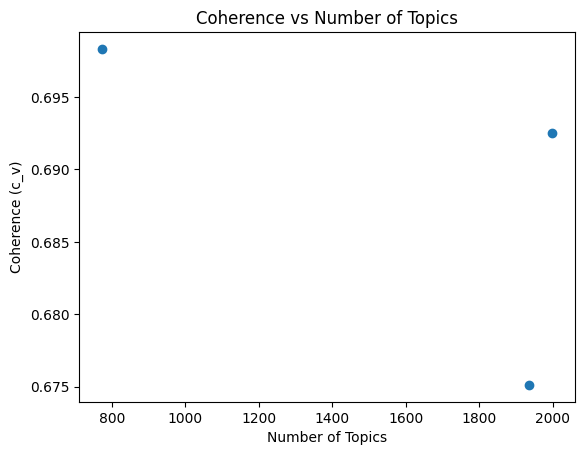

In [ ]:
plt.figure()
plt.scatter(
    results_df["n_topics"],
    results_df["coherence_c_v"]
)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence (c_v)")
plt.title("Coherence vs Number of Topics")
plt.show()


SUPERVISED TOPIC MODELING BY REPORT SECTION

In [ ]:
df["section"].value_counts().head()

,count
section,
Section 1.,7300
Section 6.,6761
Section 2.,4568
Section 7.,4287
Section 4.,1261


In [ ]:
sections = [ "Section 1.", "Section 6.", "Section 2."]

In [ ]:
def run_bertopic_on_subset(docs, embeddings_subset=None):
    topics, _ = topic_model.fit_transform(docs, embeddings_subset)
    topic_info = topic_model.get_topic_info()
    topic_info = topic_info[topic_info.Topic != -1]  # remove outliers
    return topic_info


In [ ]:
results_by_section = {}

for sec in sections:
    subset = df[df["section"] == sec]["text"].tolist()

    if len(subset) < 100:
        continue  # skip tiny sections

    topics, _ = topic_model.fit_transform(subset)

    results_by_section[sec] = topic_model.get_topic_info()


Batches:   0%|          | 0/229 [00:00<?, ?it/s]

Batches:   0%|          | 0/212 [00:00<?, ?it/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

In [ ]:
for sec, info in results_by_section.items():
    print(f"\n=== {sec} ===")
    display(info.head(5))



=== Section 1. ===


,Topic,Count,Name,Representation,Representative_Docs
1,0,5170,0_police_authorities_detention_prison,"[police, authorities, detention, prison, priso...","[translators and that, at the request of docto..."
2,1,15,1_kachin_shan_ethnic_cease,"[kachin, shan, ethnic, cease, shan state, army...","[development, tourism, and natural resource ex..."
3,2,11,2_hnp_hnp officers_michel_port,"[hnp, hnp officers, michel, port, cspj, port a...",[expertise impeded cases from being investigat...
4,3,10,3_farmers_farm_farms_white,"[farmers, farm, farms, white, owned, beneficia...",[a 24-hour lease and could be terminated for a...
5,4,10,4_rio_rio janeiro_janeiro_favela,"[rio, rio janeiro, janeiro, favela, officers, ...","[Respect for the Integrity of the Person, Incl..."



=== Section 6. ===


,Topic,Count,Name,Representation,Representative_Docs
1,0,4497,0_women_children_law_violence,"[women, children, law, violence, persons, sexu...","[rare, and the government did not keep statist..."
2,1,118,1_indigenous_lands_land_indigenous people,"[indigenous, lands, land, indigenous people, c...",[member of the Wayuu indigenous group headed t...
3,2,26,2_kosovo_albanian_serbian_albanians,"[kosovo, albanian, serbian, albanians, ethnic,...",[with disabilities in their regular classes. S...
4,3,24,3_killed_cattle_deaths_hindu,"[killed, cattle, deaths, hindu, county, confli...","[political rivalries, and the inability of sec..."
5,4,16,4_dalit_dalits_caste_manual,"[dalit, dalits, caste, manual, sc, upper, cast...",[to prosecute perpetrators or because victims ...



=== Section 2. ===


,Topic,Count,Name,Representation,Representative_Docs
1,0,3327,0_freedom_refugees_persons_law,"[freedom, refugees, persons, law, asylum, medi...","[Respect for Civil Liberties, Including: Share..."
2,1,16,1_tibetans_tibetan_tibetan refugees_nepal,"[tibetans, tibetan, tibetan refugees, nepal, n...",[that 171 Tibetans transited the country in 20...
3,2,8,2_activists_liu_traveling_detained,"[activists, liu, traveling, detained, activist...",[home but did not have freedom of movement. Fo...
4,3,7,3_nguyen_chi_minh_ho,"[nguyen, chi, minh, ho, minh city, ho chi, chi...","[including Pham Ba Hai, Nguyen Dan Que, Nguyen..."
5,4,7,4_thai_birth_stateless_certificates,"[thai, birth, stateless, certificates, childre...","[evidence of Burmese citizenship, ethnic minor..."


In [ ]:
for sec in results_by_section:
    results_by_section[sec] = results_by_section[sec][
        results_by_section[sec]["Topic"] != -1
    ]

In [ ]:
comparison_rows = []

for sec, info in results_by_section.items():
    for _, row in info.iterrows():
        comparison_rows.append({
            "section": sec,
            "topic_id": row["Topic"],
            "n_documents": row["Count"],
            "top_words": row["Name"]
        })

comparison_df = pd.DataFrame(comparison_rows)
comparison_df.head()


,section,topic_id,n_documents,top_words
0,Section 1.,0,5170,0_police_authorities_detention_prison
1,Section 1.,1,15,1_kachin_shan_ethnic_cease
2,Section 1.,2,11,2_hnp_hnp officers_michel_port
3,Section 1.,3,10,3_farmers_farm_farms_white
4,Section 1.,4,10,4_rio_rio janeiro_janeiro_favela


In [ ]:
comparison_df.sort_values(
    ["section", "n_documents"],
    ascending=[True, False]
).head(15)


,section,topic_id,n_documents,top_words
0,Section 1.,0,5170,0_police_authorities_detention_prison
1,Section 1.,1,15,1_kachin_shan_ethnic_cease
2,Section 1.,2,11,2_hnp_hnp officers_michel_port
3,Section 1.,3,10,3_farmers_farm_farms_white
4,Section 1.,4,10,4_rio_rio janeiro_janeiro_favela
5,Section 1.,5,9,5_insurgents_provinces_public health_southernmost
6,Section 1.,6,9,6_caucasus_north caucasus_dagestan_north
7,Section 1.,7,8,7_al shabaab_shabaab_al_amisom
8,Section 1.,8,8,8_land_jaffna_owners_acquisition
9,Section 1.,9,8,9_village_councils_local councils_mediation


In [ ]:
topic_counts = comparison_df.groupby("section")["topic_id"].nunique()
topic_counts


,topic_id
section,
Section 1.,107
Section 2.,64
Section 6.,148


In [ ]:
df_topics = df.copy()   # Create a copy of the original DataFrame
df_topics["topic"] = best_model.topics_ # Use the topics from the best_model, which was fitted on all documents
df_topics = df_topics[df_topics["topic"] != -1]

In [ ]:
topic_year = (
    df_topics
    .groupby(["year", "topic"])
    .size()
    .reset_index(name="count")
)

topic_year["share"] = (
    topic_year["count"] /
    topic_year.groupby("year")["count"].transform("sum")
)

In [ ]:
eu_df = df_topics[df_topics["is_eu"] == 1]
non_eu_df = df_topics[df_topics["is_eu"] == 0]

In [ ]:
eu_topics = eu_df["topic"].value_counts(normalize=True)
non_eu_topics = non_eu_df["topic"].value_counts(normalize=True)

In [ ]:
topic_compare = pd.DataFrame({
    "EU": eu_topics,
    "Non_EU": non_eu_topics
}).fillna(0)
topic_compare["difference"] = abs(topic_compare["EU"] - topic_compare["Non_EU"])
distinct_topics = topic_compare.sort_values("difference", ascending=False).head(5)

In [ ]:
# Create topic -> name mapping using top keywords
topic_labels = {
    topic: ", ".join([word for word, _ in best_model.get_topic(topic)[:5]])
    for topic in best_model.get_topics().keys()
    if topic != -1
}
df_topics["topic_name"] = df_topics["topic"].map(topic_labels)

In [ ]:
df_topics['EU_status'] = df_topics['is_eu'].map({True: 'EU', False: 'Non-EU'})

# Group by EU_status and topic_name, and count occurrences
topic_counts_by_region = df_topics.groupby(["EU_status", "topic_name"]).size().reset_index(name='count')

# Calculate the share of each topic within its EU_status group
topic_counts_by_region['share'] = topic_counts_by_region.groupby("EU_status")['count'].transform(lambda x: x / x.sum())

# Now topic_region_pivot can be created from this DataFrame
topic_region_pivot = topic_counts_by_region.pivot(
    index="topic_name",
    columns="EU_status",
    values="share"
).fillna(0)

topic_region_pivot.columns = ["Non-EU", "EU"]

In [ ]:
from collections import Counter

def extract_keywords_from_topic_name(topic_name):
    # "police / authorities / detention / prison"
    return [w.strip() for w in topic_name.split("/")]


In [ ]:
def auto_section_label(section_df, top_k=4):
    counter = Counter()

    for _, row in section_df.iterrows():
        words = extract_keywords_from_topic_name(row["topic_name"])
        # Her chunk = 1 oy (istersen ağırlık ekleyebiliriz)
        for w in words:
            counter[w] += 1

    top_words = [w for w, _ in counter.most_common(top_k)]
    return " / ".join(top_words)


In [ ]:
section_labels_df = (
    df_topics
    .groupby("section")
    .apply(auto_section_label)
    .reset_index()
)

section_labels_df.columns = ["section", "section_label_auto"]

section_labels_df

,section,section_label_auto
0,EXECUTIVE SUMMARY,"rights problems, problems included, control se..."
1,Section 1.,"arrest detention, independent monitoring, arbi..."
2,Section 2.,"protection refugees, movement, internally disp..."
3,Section 3.,"elections, change government, participation, p..."
4,Section 4.,"corruption, disclosure, public access, financi..."
5,Section 5.,"nongovernmental investigation, attitude regard..."
6,Section 6.,"international child, pornography, sexual explo..."
7,Section 7.,"labor, workers, unions, child labor, employers..."


Visualization

In [ ]:
import pandas as pd

def get_main_phrase(label):
    """
    Virgülle ayrılmış uzun label içinden
    en baskın (ilk) kısmı alır
    """
    if pd.isna(label):
        return ""
    return label.split(",")[0]


In [ ]:
def short_label_2_words(label):
    main = get_main_phrase(label)
    words = main.split()
    return " ".join(words[:2])


In [ ]:
section_labels_df["section_label_short"] = (
    section_labels_df["section_label_auto"]
    .apply(short_label_2_words)
)


Distribution of Sections

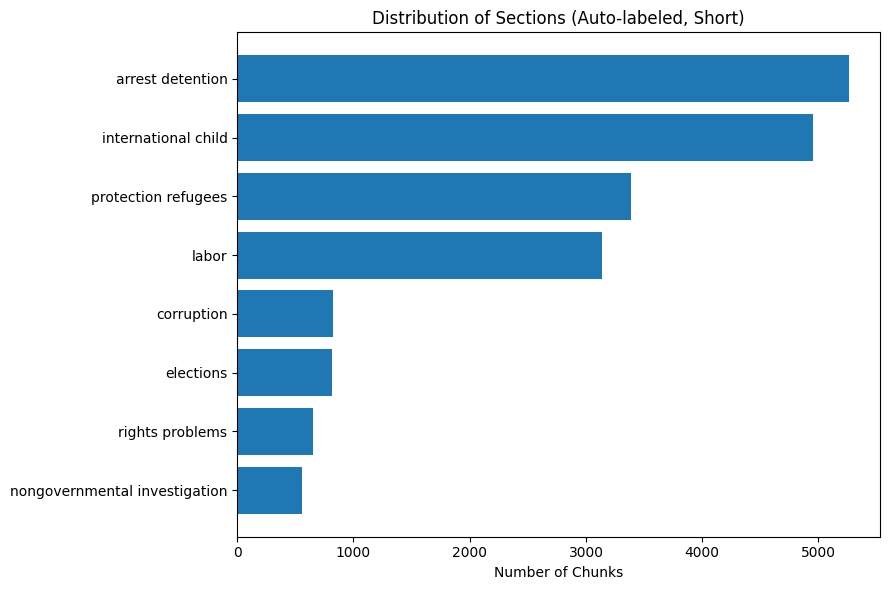

In [ ]:
section_counts = (
    df_topics
    .groupby("section")
    .size()
    .reset_index(name="n_chunks")
    .merge(section_labels_df, on="section", how="left")
    .sort_values("n_chunks")
)

plt.figure(figsize=(9, 6))
plt.barh(
    section_counts["section_label_short"],
    section_counts["n_chunks"]
)

plt.xlabel("Number of Chunks")
plt.title("Distribution of Sections (Auto-labeled, Short)")
plt.tight_layout()
plt.show()


Top Topics with Largest EU vs Non-EU Differences

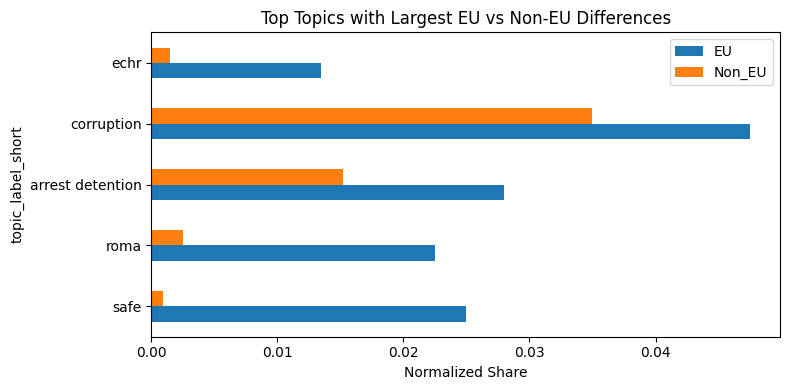

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------
# 1. Ultra-short topic label creator
# ----------------------------------
def ultra_short_label(label):
    """
    Converts long topic labels into 1–2 word concept labels.
    Example:
    'corruption, disclosure, public access, financial disclosure'
    -> 'corruption'
    """
    if pd.isna(label):
        return "unknown"

    # split by comma or slash
    tokens = (
        label
        .replace("/", ",")
        .split(",")
    )

    # take first meaningful token
    main = tokens[0].strip()

    # keep at most 2 words
    return " ".join(main.split()[:2])


# ----------------------------------
# 2. Prepare plotting dataframe
# ----------------------------------
plot_df = distinct_topics.copy().reset_index()
plot_df.columns = ["topic", "EU", "Non_EU", "difference"]

# use EXISTING topic_labels
plot_df["topic_label_full"] = plot_df["topic"].map(topic_labels)

# create ultra-short labels (like your example)
plot_df["topic_label_short"] = plot_df["topic_label_full"].apply(
    ultra_short_label
)

# use short labels as index
plot_df = plot_df.set_index("topic_label_short")


# ----------------------------------
# 3. Visualization (clean & compact)
# ----------------------------------
plot_df[["EU", "Non_EU"]].plot(
    kind="barh",
    figsize=(8, 4)
)

plt.xlabel("Normalized Share")
plt.title("Top Topics with Largest EU vs Non-EU Differences")
plt.tight_layout()
plt.show()


Topic Share Difference Between EU and Non-EU

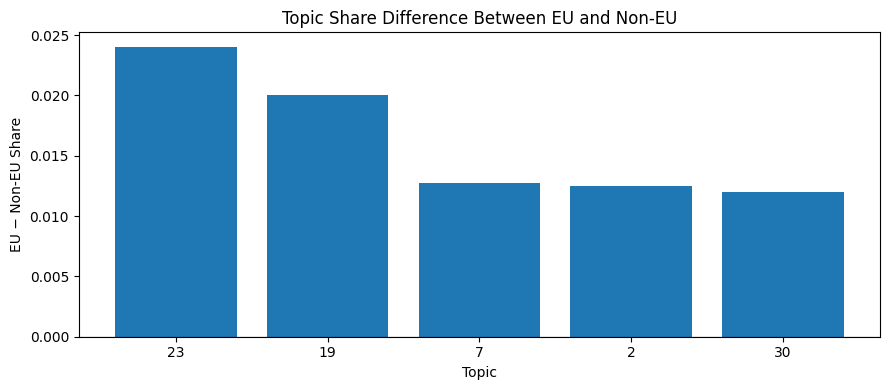

In [ ]:
plot_df["diff"] = plot_df["EU"] - plot_df["Non_EU"]

plt.figure(figsize=(9, 4))
plt.bar(
    plot_df.index.astype(str),
    plot_df["diff"]
)

plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Topic")
plt.ylabel("EU − Non-EU Share")
plt.title("Topic Share Difference Between EU and Non-EU")
plt.tight_layout()
plt.show()


Temporal Changes in Topic Distribution

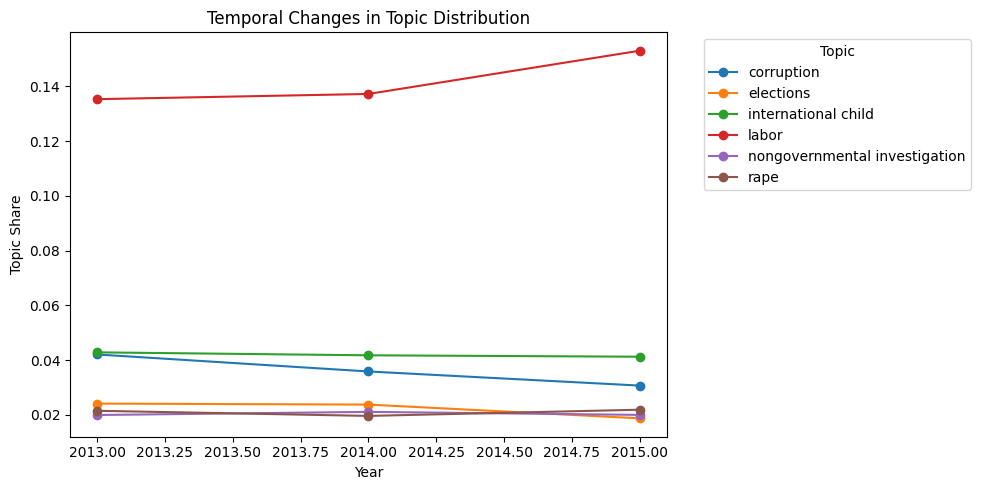

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def ultra_short_label(label):
    if pd.isna(label):
        return "unknown"
    tokens = label.replace("/", ",").split(",")
    main = tokens[0].strip()
    return " ".join(main.split()[:2])

df_temp = df_topics.copy()

df_temp["topic_label_short"] = (
    df_temp["topic_name"]
    .apply(ultra_short_label)
)

# optional: remove outliers
df_temp = df_temp[df_temp["topic"] != -1]



topic_year_counts = df_temp.groupby(["year", "topic_label_short"]).size().reset_index(name="count")
topic_year_counts["share"] = topic_year_counts["count"] / topic_year_counts.groupby("year")["count"].transform("sum")
topic_year = topic_year_counts[["year", "topic_label_short", "share"]]

top_k = 6

top_topics = (
    df_temp["topic_label_short"]
    .value_counts()
    .head(top_k)
    .index
)

topic_year_top = topic_year[
    topic_year["topic_label_short"].isin(top_topics)
]

pivot = topic_year_top.pivot(
    index="year",
    columns="topic_label_short",
    values="share"
).fillna(0)

plt.figure(figsize=(10, 5))

for col in pivot.columns:
    plt.plot(
        pivot.index,
        pivot[col],
        marker="o",
        label=col
    )

plt.xlabel("Year")
plt.ylabel("Topic Share")
plt.title("Temporal Changes in Topic Distribution")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

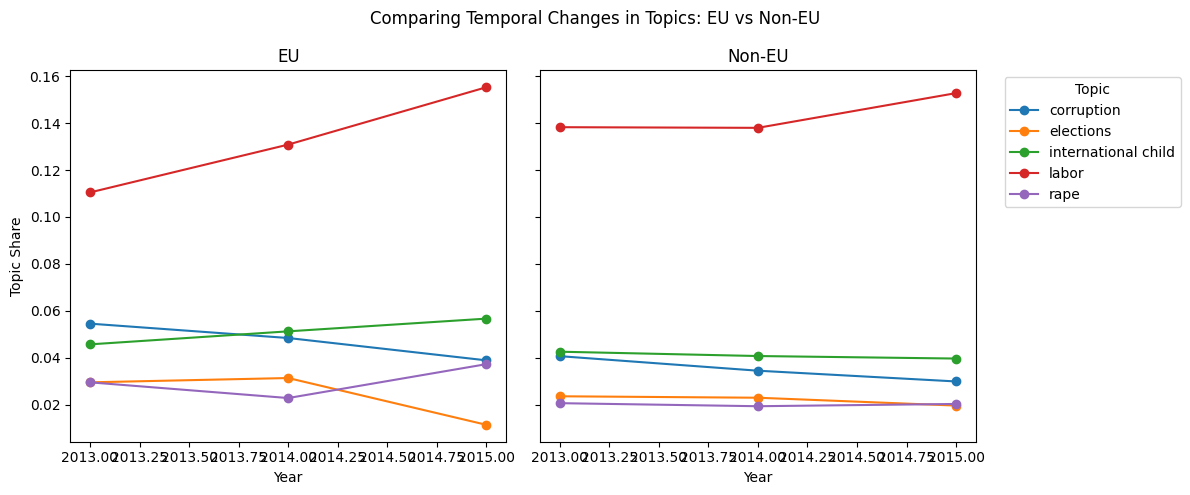

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def ultra_short_label(label):
    if pd.isna(label):
        return "unknown"
    tokens = label.replace("/", ",").split(",")
    main = tokens[0].strip()
    return " ".join(main.split()[:2])


df_temp = df_topics.copy()

df_temp["topic_label_short"] = (
    df_temp["topic_name"]
    .apply(ultra_short_label)
)

# remove outliers if any
df_temp = df_temp[df_temp["topic"] != -1]


topic_year_group = (
    df_temp
    .groupby(["EU_status", "year", "topic_label_short"], as_index=False)
    .size()
)

topic_year_group["share"] = (
    topic_year_group["size"] /
    topic_year_group.groupby(["EU_status", "year"])["size"].transform("sum")
)

top_k = 5

top_topics = (
    df_temp["topic_label_short"]
    .value_counts()
    .head(top_k)
    .index
)

topic_year_group = topic_year_group[
    topic_year_group["topic_label_short"].isin(top_topics)
]


fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, group in enumerate(["EU", "Non-EU"]):
    subset = topic_year_group[
        topic_year_group["EU_status"] == group
    ]

    pivot = subset.pivot(
        index="year",
        columns="topic_label_short",
        values="share"
    ).fillna(0)

    for col in pivot.columns:
        axes[i].plot(
            pivot.index,
            pivot[col],
            marker="o",
            label=col
        )

    axes[i].set_title(group)
    axes[i].set_xlabel("Year")

axes[0].set_ylabel("Topic Share")
axes[1].legend(
    title="Topic",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.suptitle("Comparing Temporal Changes in Topics: EU vs Non-EU")
plt.tight_layout()
plt.show()


Biggest Topic Shifts

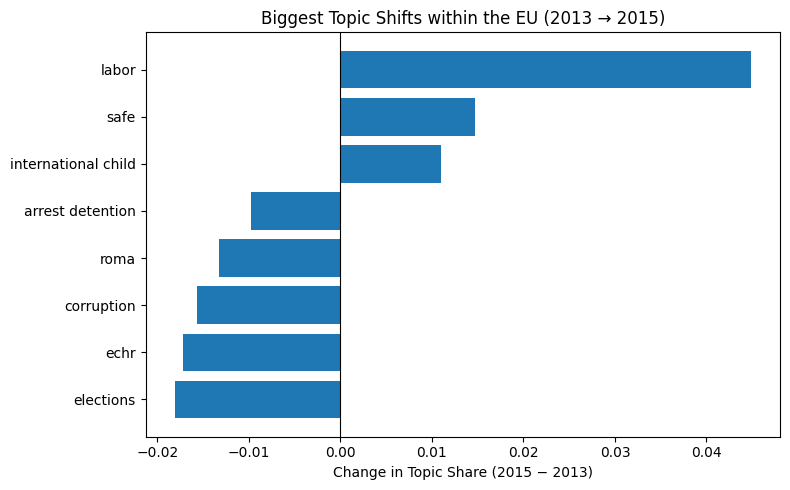

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def ultra_short_label(label):
    if pd.isna(label):
        return "unknown"
    tokens = label.replace("/", ",").split(",")
    main = tokens[0].strip()
    return " ".join(main.split()[:2])


df_eu = df_topics.copy()

df_eu = df_eu[df_eu["EU_status"] == "EU"]
df_eu = df_eu[df_eu["topic"] != -1]

df_eu["topic_label_short"] = (
    df_eu["topic_name"]
    .apply(ultra_short_label)
)


topic_year_eu = (
    df_eu
    .groupby(["year", "topic_label_short"], as_index=False)
    .size()
)

topic_year_eu["share"] = (
    topic_year_eu["size"] /
    topic_year_eu.groupby("year")["size"].transform("sum")
)

pivot = topic_year_eu.pivot(
    index="topic_label_short",
    columns="year",
    values="share"
).fillna(0)

# keep only 2013 and 2015
pivot = pivot[[2013, 2015]]

pivot["shift_2013_2015"] = pivot[2015] - pivot[2013]

# select biggest absolute shifts
top_shifts = (
    pivot["shift_2013_2015"]
    .abs()
    .sort_values(ascending=False)
    .head(8)
    .index
)

shift_df = pivot.loc[top_shifts].sort_values("shift_2013_2015")


plt.figure(figsize=(8, 5))
plt.barh(
    shift_df.index,
    shift_df["shift_2013_2015"]
)

plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Change in Topic Share (2015 − 2013)")
plt.title("Biggest Topic Shifts within the EU (2013 → 2015)")
plt.tight_layout()
plt.show()


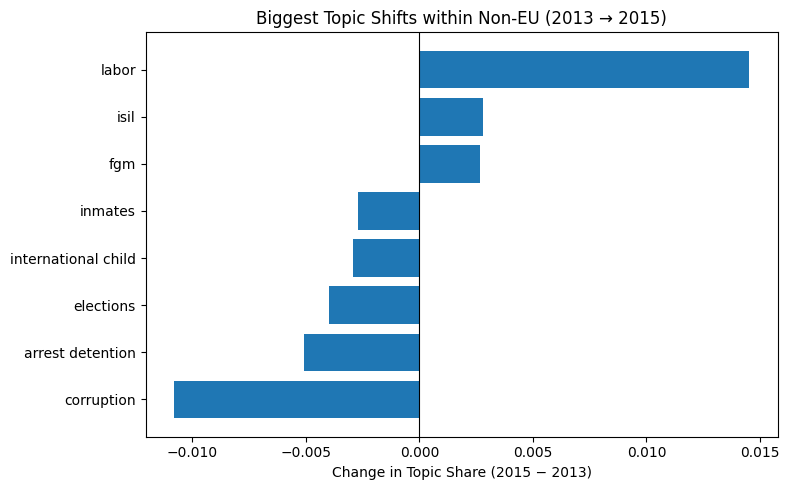

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def ultra_short_label(label):
    if pd.isna(label):
        return "unknown"
    tokens = label.replace("/", ",").split(",")
    main = tokens[0].strip()
    return " ".join(main.split()[:2])


df_noneu = df_topics.copy()

df_noneu = df_noneu[df_noneu["EU_status"] == "Non-EU"]
df_noneu = df_noneu[df_noneu["topic"] != -1]

df_noneu["topic_label_short"] = (
    df_noneu["topic_name"]
    .apply(ultra_short_label)
)

topic_year_noneu = (
    df_noneu
    .groupby(["year", "topic_label_short"], as_index=False)
    .size()
)

topic_year_noneu["share"] = (
    topic_year_noneu["size"] /
    topic_year_noneu.groupby("year")["size"].transform("sum")
)

pivot = topic_year_noneu.pivot(
    index="topic_label_short",
    columns="year",
    values="share"
).fillna(0)

# keep only 2013 and 2015
pivot = pivot[[2013, 2015]]

pivot["shift_2013_2015"] = pivot[2015] - pivot[2013]

# select biggest absolute shifts
top_shifts = (
    pivot["shift_2013_2015"]
    .abs()
    .sort_values(ascending=False)
    .head(8)
    .index
)

shift_df = pivot.loc[top_shifts].sort_values("shift_2013_2015")


plt.figure(figsize=(8, 5))
plt.barh(
    shift_df.index,
    shift_df["shift_2013_2015"]
)

plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Change in Topic Share (2015 − 2013)")
plt.title("Biggest Topic Shifts within Non-EU (2013 → 2015)")
plt.tight_layout()
plt.show()


Conclusion

This study applied topic modeling to systematically examine the thematic structure and evolution of human rights reporting across EU and non-EU countries between 2013 and 2015. By combining automatically generated topic labels with normalized comparisons and temporal analyses, the findings provide a structured and interpretable overview of both regional and temporal differences in topic salience.

The comparative analysis reveals clear distinctions between EU and non-EU countries in terms of thematic emphasis. While both groups address a broad spectrum of human rights issues, EU countries tend to place relatively greater emphasis on topics related to detention practices, corruption, and procedural safeguards, whereas non-EU countries show comparatively higher attention to governance-related and institutional accountability themes. Importantly, these differences persist even after normalizing for document volume, indicating substantive variation in topic prioritization rather than simple differences in reporting intensity.

Temporal analyses further demonstrate that topic salience is not static but evolves over time. Several topics exhibit notable shifts in prominence between 2013 and 2015, reflecting changing thematic priorities within both regions. The analysis of the largest topic shifts highlights that some trends are shared across regions, suggesting global developments, while others diverge markedly between EU and non-EU countries, underscoring the influence of regional political and institutional contexts.

Overall, the results suggest that human rights reporting is shaped by a combination of regional characteristics and temporal dynamics. The methodological approach employed in this study—integrating topic modeling, automated label reduction, and comparative temporal analysis—offers a reproducible and scalable framework for analyzing large collections of policy-relevant texts. Future research could extend this framework by incorporating longer time horizons, country-level analyses, or external political and socio-economic indicators to further contextualize observed thematic shifts.